In [ ]:
!pip install catboost
!pip install scikit-uplift

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
SEED = 24

In [ ]:
#Чтение данных
df = pd.read_csv('data.csv')
df.head()

recency  history  used_discount  ...  channel            offer  conversion
0       10   142.44              1  ...    Phone  Buy One Get One           0
1        6   329.08              1  ...      Web         No Offer           0
2        7   180.65              0  ...      Web  Buy One Get One           0
3        9   675.83              1  ...      Web         Discount           0
4        2    45.34              1  ...      Web  Buy One Get One           0

[5 rows x 9 columns]

In [ ]:
df.rename(columns={"offer": "treatment", "conversion": "target"}, inplace=True)

In [ ]:
df['treatment'] = np.where((df.treatment == 'No Offer'),0,1)

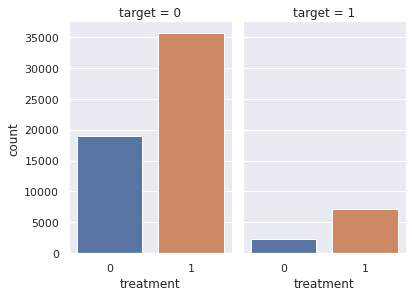

In [ ]:
sns.catplot(x="treatment", col="target",
                data=df, kind="count",
                height=4, aspect=.7);

Aнализ данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [47]:
#cat_features = ['zip_code', 'channel', 'recency', 'used_discount', 'used_bogo', 'is_referral']
cat_features = ['zip_code', 'channel']
bin_features = ['recency', 'used_discount', 'used_bogo', 'is_referral']
num_features = ['history']
feature_cols = cat_features + num_features + bin_features
target = 'target'
treat = 'treatment'

In [48]:
for cat in cat_features:
    print(df[cat].value_counts(), '\n')

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64 

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64 



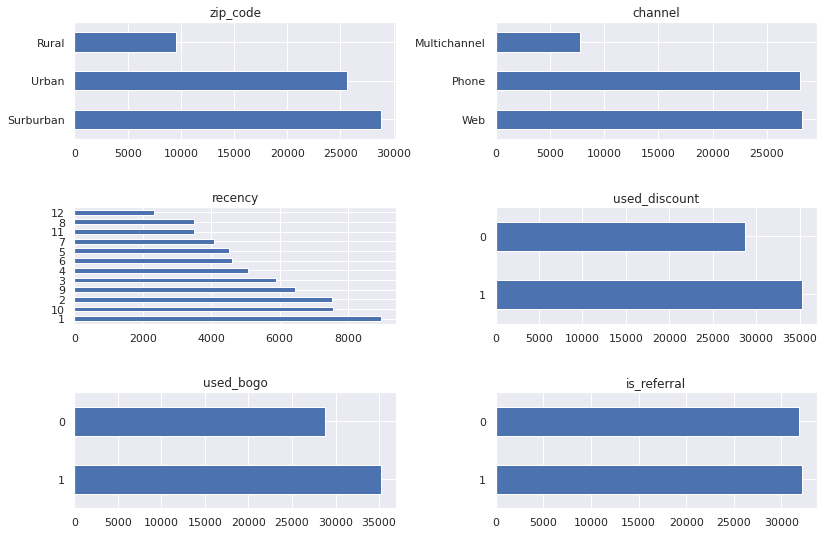

In [ ]:
fig, ax = plt.subplots(3, 2)
fig.tight_layout()
for i, ax in enumerate(ax.flat):
    df[cat_features[i]].value_counts().plot(kind="barh", ax=ax, figsize=(12,8)).set_title(cat_features[i])

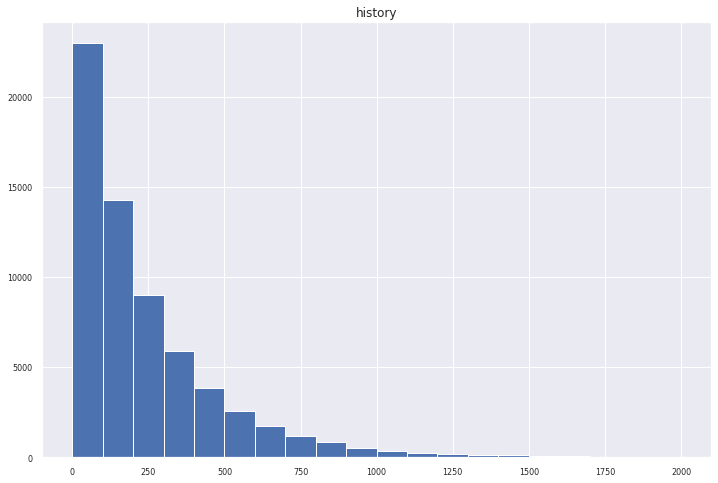

In [ ]:
df[num_features].hist(figsize=(12, 8), bins=20, xlabelsize=8, ylabelsize=8, range=(0, 2000)) ;

(0.0, 1000.0)

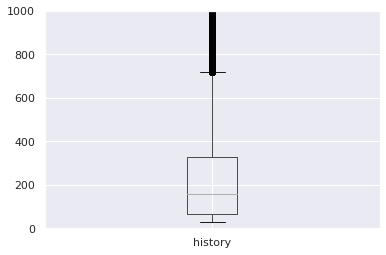

In [ ]:
df[num_features].boxplot()
plt.ylim(0,1000)

Разобьем данные

In [49]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df[feature_cols + [treat]], df[target], test_size=0.3, random_state=SEED)

In [50]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
}

#### Одна модель с признаком коммуникации

In [51]:
X_train = X_train_full[feature_cols]
y_train = y_train_full
treat_train = X_train_full[treat]

In [52]:
X_val = X_test_full[feature_cols]
y_val = y_test_full
treat_val = X_test_full[treat]

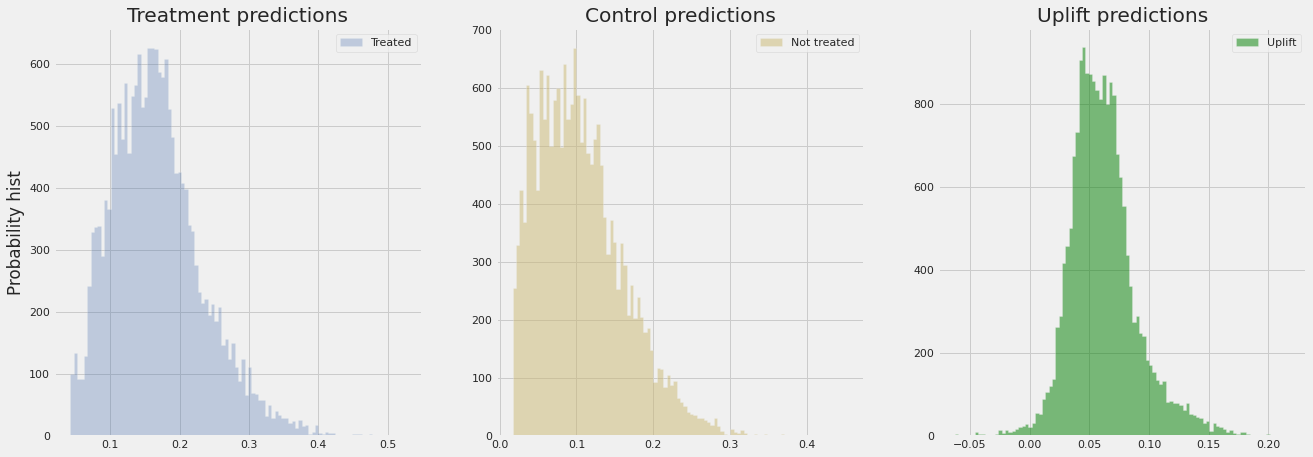

In [53]:
sm = SoloModel(CatBoostClassifier(iterations=100, random_state=SEED, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [54]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

feature_name  feature_score
0        history      20.279231
1      treatment      15.877462
2    is_referral      15.372682
3        recency      14.415325
4       zip_code       9.904836
5        channel       9.025370
6      used_bogo       8.325692
7  used_discount       6.799403

#### Трансформация классов

In [55]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=100, random_state=SEED, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


#### Две независимые модели

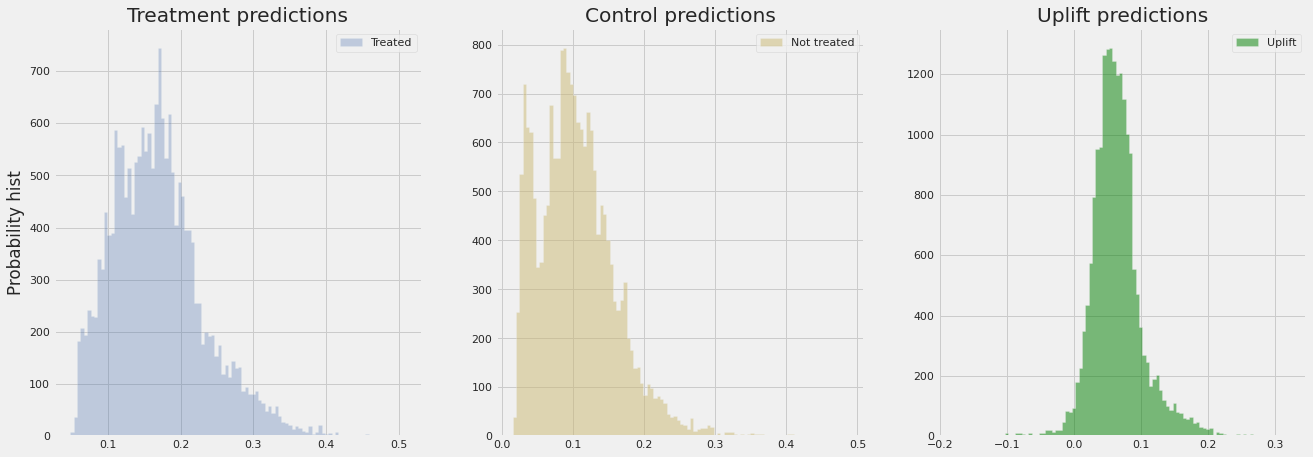

In [56]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100, random_state=SEED, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=100, random_state=SEED, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@10%'].append(tm_score_10)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [57]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

approach  uplift@10%  uplift@20%
0            SoloModel    0.109199    0.087973
1  ClassTransformation    0.088246    0.082270
2            TwoModels    0.061686    0.076735

#### Вариант с деревом решений

In [58]:
X_train_tree = pd.concat([X_train.drop(['zip_code', 'channel'], axis=1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'),
                          pd.get_dummies(X_train['channel'], prefix='channel')
                         ], 1)
features = [col for col in X_train_tree]

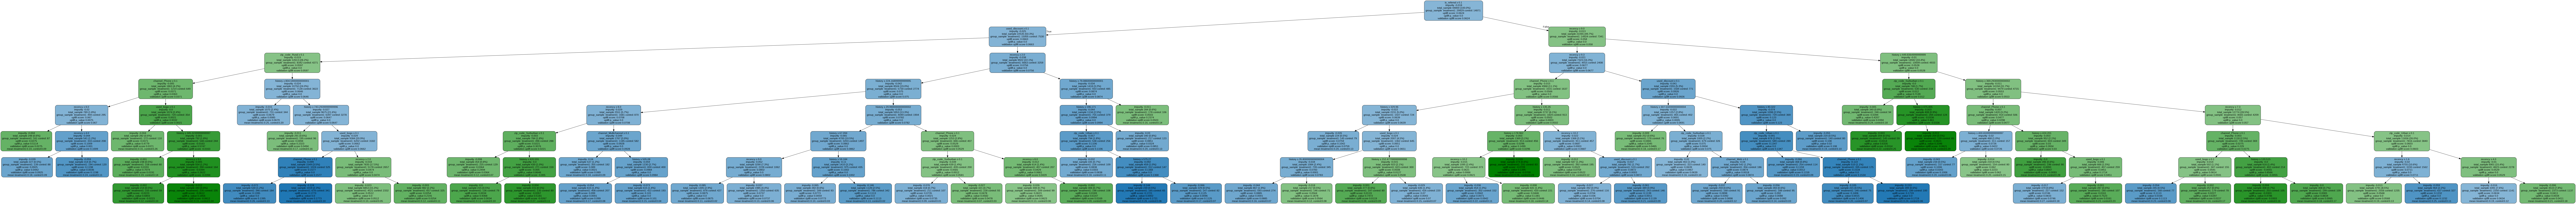

In [59]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

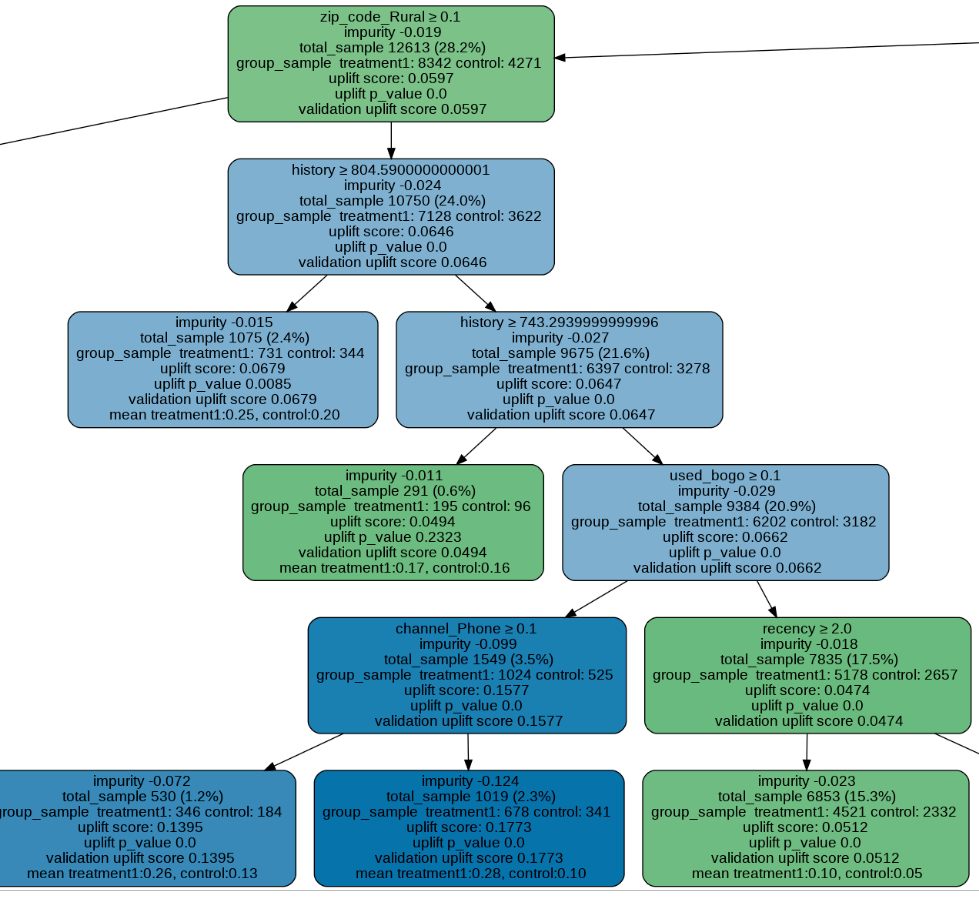

Не плохие листки внизу, имеем среднее с коммуникацие 0.26.

Если смотреть выше, это группа, которая:

- is_referral = 1
- used_discount = 1
- zip_code_Rural = 0
- history < 805
- used_bogo = 1
- channel_Phone = 1

Это люди, пришедшие по рефералке, использовал дискоунт и BoGo, потратил меньше 805, и не из Rural(деревни) района

(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

In [79]:
uplift_test = X_val.copy()
uplift_test['conversion'] = y_val
uplift_test['Uplift'] = uplift_sm

In [80]:
uplift_test['decil'] = pd.qcut(uplift_test.sort_values(by='Uplift', ascending=False)['Uplift'], 10)

In [82]:
uplift_test.groupby('decil')['conversion'].mean()

decil
(-0.0636, 0.0308]    0.159896
(0.0308, 0.0399]     0.122661
(0.0399, 0.0461]     0.113257
(0.0461, 0.0522]     0.119023
(0.0522, 0.0586]     0.142932
(0.0586, 0.065]      0.142634
(0.065, 0.0715]      0.142336
(0.0715, 0.08]       0.165104
(0.08, 0.0971]       0.157730
(0.0971, 0.218]      0.206357
Name: conversion, dtype: float64

(опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [94]:
uplift_model_rfc = UpliftRandomForestClassifier(n_estimators=10, max_depth = 5, 
                                                min_samples_leaf = 200, 
                                                min_samples_treatment = 50,
                                                n_reg = 100, 
                                                evaluationFunction='KL',
                                                control_name='control')

uplift_model_rfc.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)



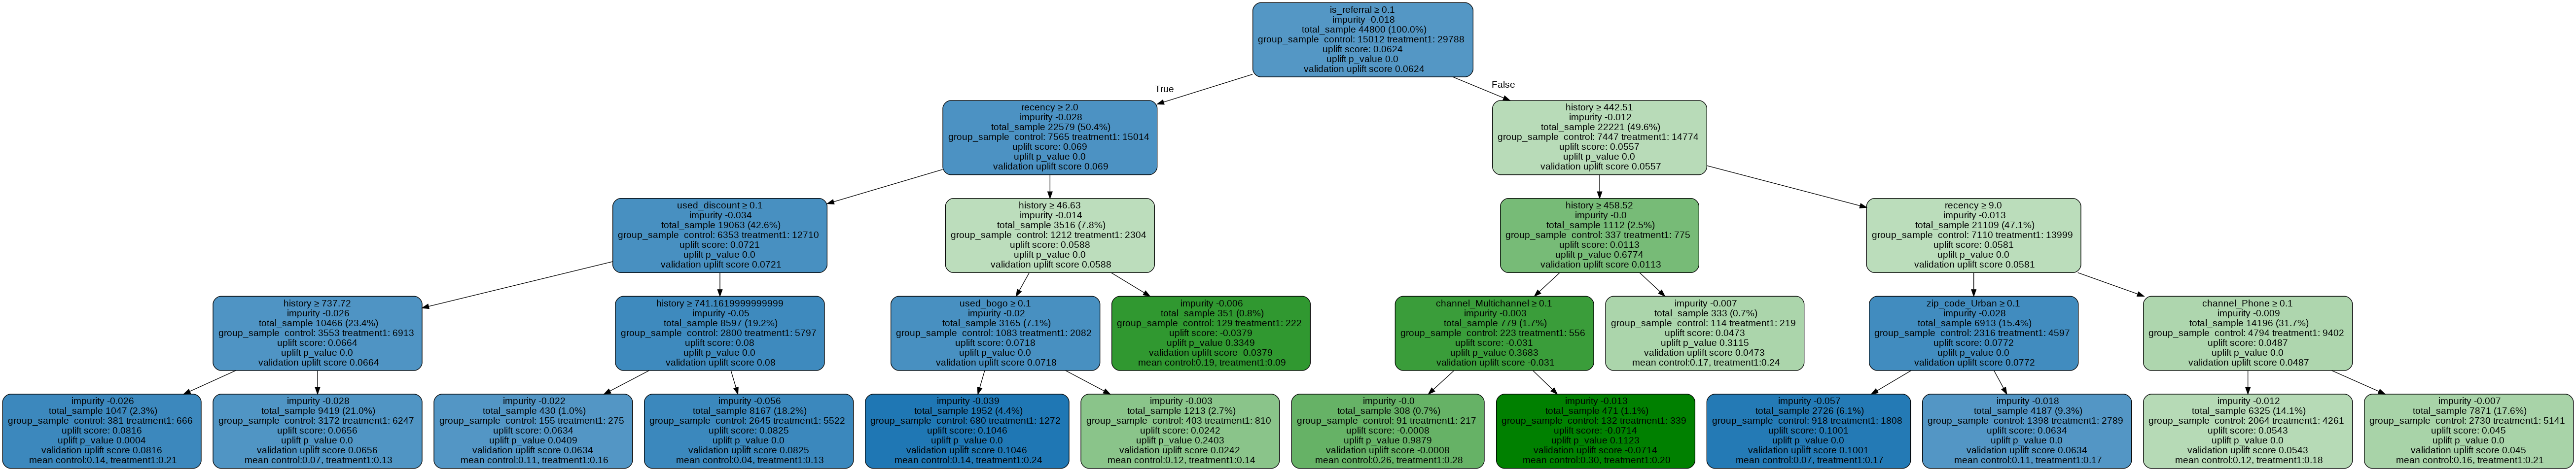

In [95]:
#Выбрать дерево для отображения из леса
uplift_tree = uplift_model_rfc.uplift_forest[0]

graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,features)
Image(graph.create_png())
